# Эволюционные алгоритмы и генетическое программирование

**Цель работы:** изучение принципов эволюционного моделирования и практическое применение генетических алгоритмов для решения оптимизационных задач и синтеза программ.

**Постановка задачи:** Реализовать эволюционный алгоритм для решения одной из предложенных задач. 
Вариант 68. Синтез математических выражений.Подбор функции, аппроксимирующей заданный набор точек, с помощью генетического программирования.


### Определения
Эволюционные алгоритмы (ЭА) - это класс стохастических оптимизационных методов, основанных на принципах естественного отбора и эволюции биологических популяций. Основная идея заключается в том, что множество решений задачи (популяция) эволюционирует во времени с использованием механизмов, аналогичных естественному отбору, генетике и мутациям.

Генетическое программирование (ГП) - это разновидность эволюционных алгоритмов, где особи представляют собой программы или математические выражения, а задача сводится к поиску оптимальной программы, выполняющей заданную функцию или аппроксимирующей данные.

### Принцип работы генетического алгоритма

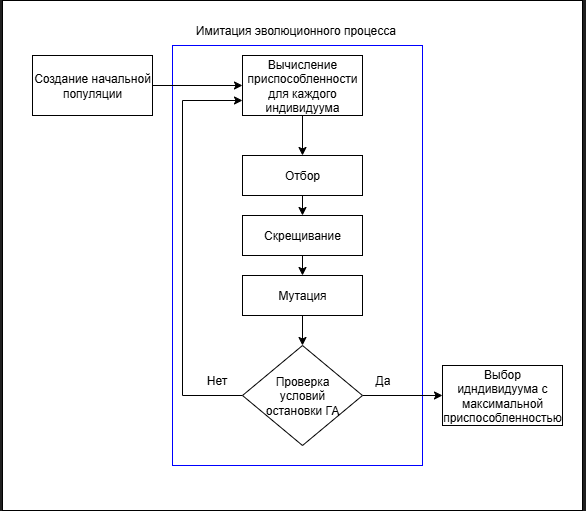


### Определить представление особи (хромосомы) в популяции, адекватное задаче.


В генетическом программировании особь - это дерево выражений, где:
* вершины представляют операторы (+, -, *, /, sin, exp и др.);
* листья — терминалы (переменные x, константы, случайные числа).

Пример дерева выражений для функции $f(x)=x^2+3$

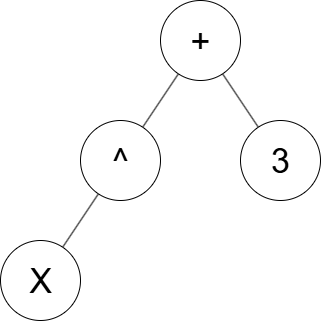


Определим классы для особей
Класс Node является базовым для представления особей в популяции. Каждый узел дерева реализует методы evaluate(x) для вычисления значения выражения при заданном x, copy() для создания копии узла при операциях кроссовера и мутации, а также __repr__() для визуализации дерева. Конкретные узлы (Var, Const, BinaryOp) наследуют этот класс и реализуют переменные, константы и бинарные операции соответственно.

In [244]:
import random
import matplotlib.pyplot as plt
import numpy as np


class Node:
    def evaluate(self, x):
        raise NotImplementedError()
    
    def copy(self):
        raise NotImplementedError()
    
    def __repr__(self):
        raise NotImplementedError()

Класс BinaryOp наследует Node и представляет бинарную операцию с левым и правым поддеревьями.

In [245]:
class BinaryOp(Node):

    def __init__(self, op, left, right):
        self.op = op
        self.left = left
        self.right = right
    
    def evaluate(self, x):

        a = self.left.evaluate(x)

        b = self.right.evaluate(x)

        try:
            match self.op:
                case '+':
                    return a + b
                case '-':
                    return a - b
                case '*':
                    return a * b
                case '/':
                    return a / b if b != 0 else 1e6
                case '^':
                    if a < 0 and not float(b).is_integer():
                        return 1e6
                    if a == 0 and b < 0:
                        return 1e6
                    if abs(a) > 1e3 or abs(b) > 10:
                        return 1e6
                    return a ** b
        except (OverflowError, ValueError, ZeroDivisionError, FloatingPointError):
            return 1e6
    
    def copy(self):
        return BinaryOp(self.op, self.left.copy(), self.right.copy())
    
    def __repr__(self):
        return f"({self.left} {self.op} {self.right})"

Класс Var наследует Node и представляет переменную x

In [246]:
class Var(Node):

    def evaluate(self, x):
        return x
    
    def copy(self):
        return Var()
    
    def __repr__(self):
        return f"x"

Класс Const наследует Node и представляет константу.

In [247]:
class Const(Node):

    def __init__(self, value):
        self.value = value

    def evaluate(self, x):
        return self.value

    def copy(self):
        return Const(self.value)
    
    def __repr__(self):
        return str(self.value)

Функция generate_random_tree() создаёт случайное дерево выражения заданной глубины, где листья — это либо переменная x, либо случайная константа, а внутренние узлы — бинарные операции (+, -, *, /, ^). Функция generatePopulation() формирует популяцию из n таких деревьев, используя generate_random_tree, что позволяет генетическому алгоритму работать с набором разнообразных особей.

In [248]:
operators_binary = ['+', '-', '*', '/', '^']

def generate_random_tree(depth=3):
    if depth == 0:
        if random.random() < 0.5:
            return Var()
        else:
            # return Const(random.uniform(-5, 5))
            return Const(random.randint(-5, 5))
        
    op = random.choice(operators_binary)
    left = generate_random_tree(depth - 1)
    right = generate_random_tree(depth - 1)
    return BinaryOp(op, left, right)

In [249]:
def generatePopulation(n=100, depth=3):
    Populations = []
    for i in range(n):
        Populations.append(generate_random_tree(depth))
    
    return Populations

### Функция приспособленности (fitness function)

Функция приспособленности (fitness function) — это мера качества решения в эволюционных алгоритмах. Она оценивает, насколько хорошо особь (решение) справляется с поставленной задачей. В генетическом программировании значение функции приспособленности определяет вероятность того, что особь будет выбрана для размножения в следующем поколении.  

В качестве функции приспособленности в данной задаче используется среднеквадратичная ошибка (MSE) между значениями, предсказанными особью $f_\text{ind}(x)$, и фактическими значениями из набора точек $(x_i, y_i)$:  

$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} \left(y_i - f_\text{ind}(x_i)\right)^2$$

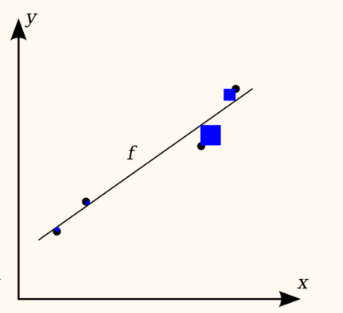

Для того чтобы алгоритм максимизировал приспособленность, значение MSE можно преобразовать в fitness следующим образом:  

$$\text{fitness} = \frac{1}{1 + \text{MSE}}$$

Таким образом, чем меньше ошибка аппроксимации, тем выше приспособленность особи, что соответствует лучшему решению задачи синтеза функции.



In [250]:
def tree_size(node: Node):
    if isinstance(node, BinaryOp):
        return 1 + tree_size(node.left) + tree_size(node.right)
    else:
        return 1  # Var или Const

def fitness(individual: Node, X, Y, alpha=0.01):
    errors = []
    for x_val, y_true in zip(X, Y):
        try:
            y_pred = individual.evaluate(x_val)
        except:
            return float("inf")

        if not np.isfinite(y_pred):
            return float("inf")

        errors.append((y_pred - y_true) ** 2)
    
    mse = np.mean(errors)
    size_penalty = alpha * tree_size(individual)
    
    return 1 / (1 + mse + size_penalty)

### Реализовать генетические операторы: селекцию, скрещивание (кроссовер), мутацию.

Функция get_all_nodes(node) рекурсивно собирает все узлы дерева вместе с информацией о родителе и положении узла (левый или правый ребёнок). Это необходимо для реализации генетических операторов, таких как кроссовер и мутация, чтобы можно было выбрать и заменить любой узел дерева.

In [251]:
def get_all_nodes(node, parent=None, is_left=None, nodes=None): ### список узлов, (узел, родитель, левый)
    if nodes is None:
        nodes = []
    
    nodes.append((node, parent, is_left))
    
    if isinstance(node, BinaryOp):
        get_all_nodes(node.left, node, True, nodes)
        get_all_nodes(node.right, node, False, nodes)
    
    return nodes

#### Селекция

Селекция выбирает лучшую особь из случайной подвыборки k особей популяции. Среди выбранных определяется индивид с наибольшей приспособленностью, который затем копируется для формирования нового поколения.

In [252]:
def tournament_selection(population, fitnesses, k=3):
    selected = random.sample(list(range(len(population))), k)
    best = max(selected, key=lambda idx: fitnesses[idx])
    return population[best].copy()

#### Кроссовер

Кроссовер выполняет обмен поддеревьями между двумя родительскими особями. Сначала создаются копии родителей, затем случайно выбираются узлы для обмена. Если выбранный узел — корень, поддерево полностью заменяет родителя. В остальных случаях поддеревья меняются местами, формируя двух потомков с комбинированными признаками родителей.

In [253]:
def crossover(parent1, parent2):
    p1 = parent1.copy()
    p2 = parent2.copy()

    nodes1 = get_all_nodes(p1)
    nodes2 = get_all_nodes(p2)

    node1, parent1, is_left1 = random.choice(nodes1)
    node2, parent2, is_left2 = random.choice(nodes2)

    if parent1 is None:
        return node2.copy(), p2
    if parent2 is None:
        return p1, node1.copy()

    if is_left1:
        parent1.left = node2.copy()
    else:
        parent1.right = node2.copy()

    if is_left2:
        parent2.left = node1.copy()
    else:
        parent2.right = node1.copy()

    return p1, p2

### Мутация

Мутация случайным образом заменяет узел дерева на новое случайное поддерево с заданной вероятностью mutation_rate. Выбирается случайный узел, создаётся новое поддерево через generate_random_tree, и оно заменяет выбранный узел, формируя модифицированного потомка для популяции.

In [254]:
def mutate(individual: Node, max_depth=1, mutation_rate=0.2):
    
    if(random.random() > mutation_rate):
        return individual.copy()
    
    ind = individual.copy()

    nodes = get_all_nodes(ind)

    node, parent, is_left = random.choice(nodes)

    new_subtree = generate_random_tree(depth=max_depth)

    if parent is None:
        return new_subtree
    
    if is_left:
        parent.left = new_subtree
    else:
        parent.right = new_subtree

    return ind


#### Реальзация алгоритма эволюции

На каждом поколении вычисляется приспособленность особей, сохраняется лучший индивид (элита), затем формируется новое поколение с помощью селекции, кроссовера и мутации. После заданного числа поколений возвращается лучшая особь, аппроксимирующая заданные данные.

In [255]:
def genetic_algorithm(X, Y, pop_size=50, n_gen=30, depth=2, mutation_rate=0.2):
    population = generatePopulation(pop_size, depth)
    best_fitness_history = []
    avg_fitness_history = []

    for gen in range(n_gen):
        fitnesses = [fitness(ind, X, Y) for ind in population]
        best_fitness_history.append(max(fitnesses))
        avg_fitness_history.append(np.mean(fitnesses))

        new_population = []

        #сохраняем лучшего
        best_idx = np.argmax(fitnesses)
        best_individual = population[best_idx].copy()
        new_population.append(best_individual)



        while len(new_population) < pop_size:
            # Селекция
            parent1 = tournament_selection(population, fitnesses)
            parent2 = tournament_selection(population, fitnesses)

            # Кроссовер
            child1, child2 = crossover(parent1, parent2)

            # Мутация
            child1 = mutate(child1, max_depth=depth, mutation_rate=mutation_rate)
            child2 = mutate(child2, max_depth=depth, mutation_rate=mutation_rate)

            new_population.extend([child1, child2])

        population = new_population[:pop_size]

        # Печать прогресса
        # print(f"Поколение {gen+1}: Лучшая приспособленность = {best_fitness_history[-1]:.6f}")

    # Лучшая особь
    final_fitnesses = [fitness(ind, X, Y) for ind in population]
    best_idx = np.argmax(final_fitnesses)
    best_individual = population[best_idx]

    return best_individual, best_fitness_history

### Провести эксперименты по настройке параметров эволюционного процесса (размер популяции, вероятность мутации и кроссовера, стратегия селекции)

Для начала сгенерируем набор данных X и Y, который будем аппроксимировать с помощью генетического программирования. Данные создаются функцией target_func(x) с добавлением небольшого шума noise для моделирования реальных измерений. Точки визуализируются на графике, что позволяет наглядно оценить распределение данных.

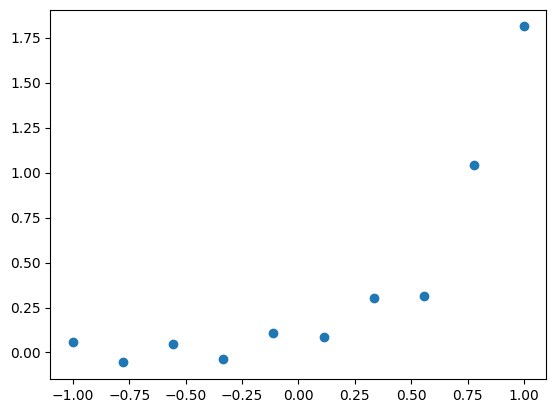

In [256]:


def generate_dataset(func, x_min=-1, x_max=1, n=50, noise=0.0, seed=0):
    rnd = random.Random(seed)
    xs = [x_min + i*(x_max-x_min)/(n-1) for i in range(n)]
    ys = [func(x) + rnd.uniform(-noise, noise) for x in xs]
    return np.array(xs), np.array(ys)

def target_func(x):
    return x**3+x**2


X, Y = generate_dataset(target_func, x_min=-1, x_max=1, n=10, noise=0.2, seed=42)

plt.scatter(X, Y)
plt.show()

Запустим эволюционный алгоритм для поиска функции, аппроксимирующей заданные данные. Параметры: размер популяции 200 особей, 100 поколений, максимальная глубина дерева 3, вероятность мутации 0.5. В конце алгоритм возвращает лучшую особь best и её приспособленность fitness(best, X, Y), которая показывает, насколько найденная функция соответствует исходным данным.

In [257]:
best, best_fitness_history = genetic_algorithm(X, Y, pop_size=200, n_gen=100, depth=3, mutation_rate=0.1)
print("Лучший результат:", best)
print("Fitness:", fitness(best, X, Y))

Лучший результат: (x / (2 - x))
Fitness: 0.8583557347995034


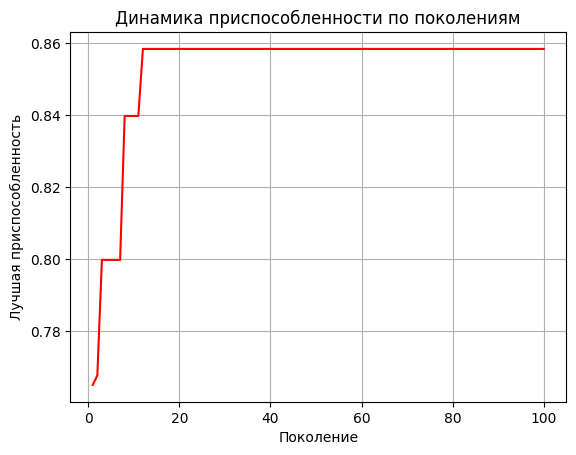

In [258]:
plt.plot(range(1, len(best_fitness_history)+1), best_fitness_history, color='red')
plt.xlabel('Поколение')
plt.ylabel('Лучшая приспособленность')
plt.title('Динамика приспособленности по поколениям')
plt.grid(True)
plt.show()

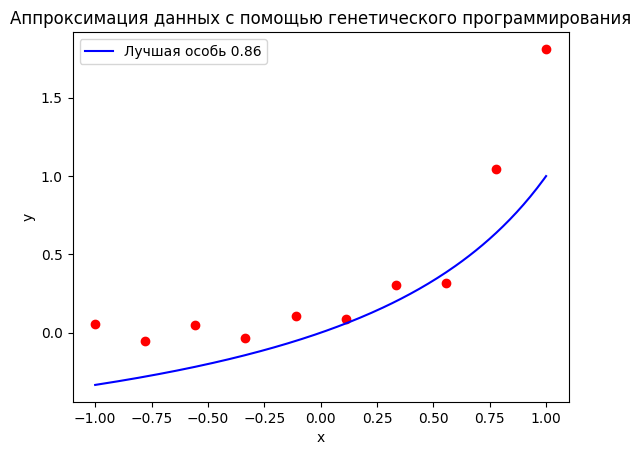

In [259]:
plt.scatter(X, Y, color='red')
X_plot = np.linspace(-1, 1, 200)  
Y_pred = [best.evaluate(x) for x in X_plot]
plt.plot(X_plot, Y_pred, color='blue',label=f'Лучшая особь {fitness(best, X, Y).round(2)}')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Аппроксимация данных с помощью генетического программирования')
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_1000\1843170530.py:31: RuntimeWarning: overflow encountered in scalar power
  return a ** b


Лучший результат: (((2 ^ x) * (3 * 5)) ^ (4 * (x / -3)))
Fitness: 0.7111972633803585


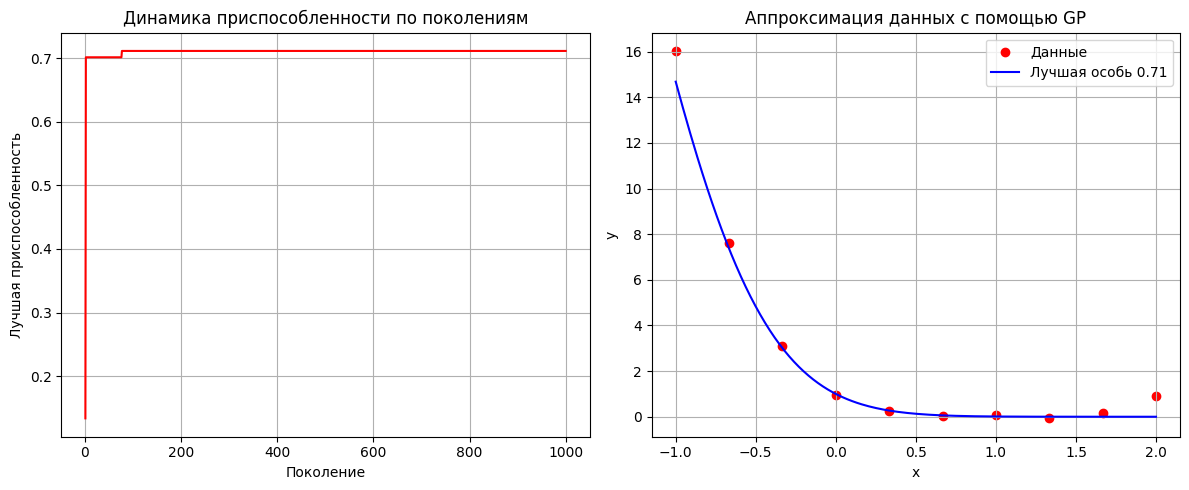

In [260]:


def target_func(x):
     return x**4 - 4*x**3 + 6*x**2 - 4*x + 1

x_min, x_max = -1, 2


X, Y = generate_dataset(target_func, x_min=x_min, x_max=x_max, n=10, noise=0.1, seed=42)

best, best_fitness_history = genetic_algorithm(X, Y, pop_size=100, n_gen=1000, depth=3, mutation_rate=0.2)
print("Лучший результат:", best)
print("Fitness:", fitness(best, X, Y))

fig, axs = plt.subplots(1, 2, figsize=(12, 5)) 


axs[0].plot(range(1, len(best_fitness_history)+1), best_fitness_history, color='red')
axs[0].set_xlabel('Поколение')
axs[0].set_ylabel('Лучшая приспособленность')
axs[0].set_title('Динамика приспособленности по поколениям')
axs[0].grid(True)


axs[1].scatter(X, Y, color='red', label='Данные')
X_plot = np.linspace(x_min, x_max, 200)
Y_pred = [best.evaluate(x) for x in X_plot]
axs[1].plot(X_plot, Y_pred, color='blue', label=f'Лучшая особь {fitness(best, X, Y).round(2)}')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_title('Аппроксимация данных с помощью GP')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()